## Load data

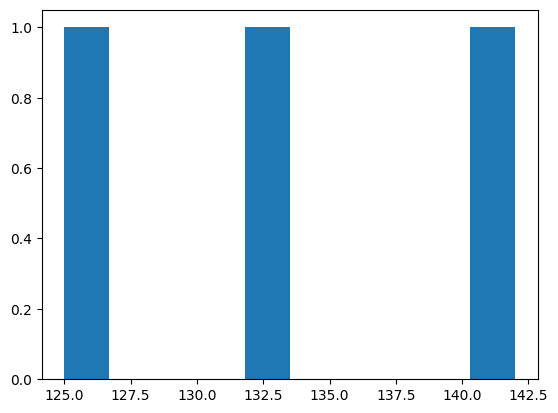

The statistics of article length: count      3.000000
mean     133.333333
std        8.504901
min      125.000000
25%      129.000000
50%      133.000000
75%      137.500000
max      142.000000
dtype: float64


In [2]:
abstracts = {
"bert":
 """ We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models, BERT is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications.
BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1 question answering Test F1 to 93.2 (1.5 point absolute improvement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point absolute improvement).
""",
"roberta":
 """Language model pretraining has led to significant performance gains but careful comparison between different approaches is challenging. Training is computationally expensive, often done on private datasets of different sizes, and, as we will show, hyperparameter choices have significant impact on the final results. We present a replication study of BERT pretraining (Devlin et al., 2019) that carefully measures the impact of many key hyperparameters and training data size. We find that BERT was significantly undertrained, and can match or exceed the performance of every model published after it. Our best model achieves state-of-the-art results on GLUE, RACE and SQuAD. These results highlight the importance of previously overlooked design choices, and raise questions about the source of recently reported improvements. We release our models and code.
""",
 "albert":
 """
 Increasing model size when pretraining natural language representations often results in improved performance on downstream tasks. However, at some point further model increases become harder due to GPU/TPU memory limitations and longer training times. To address these problems, we present two parameter-reduction techniques to lower memory consumption and increase the training speed of BERT. Comprehensive empirical evidence shows that our proposed methods lead to models that scale much better compared to the original BERT. We also use a self-supervised loss that focuses on modeling inter-sentence coherence, and show it consistently helps downstream tasks with multi-sentence inputs. As a result, our best model establishes new state-of-the-art results on the GLUE, RACE, and \squad benchmarks while having fewer parameters compared to BERT-large. The code and the pretrained models are available at this https URL.
 F"""
}

abs_intro = {
 "bert":
 """ We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models, BERT is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications.
BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1 question answering Test F1 to 93.2 (1.5 point absolute improvement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point absolute improvement).
Language model pre-training has been shown to be effective for improving many natural language processing tasks (Dai and Le, 2015; Peters et al., 2018a; Radford et al., 2018; Howard and Ruder, 2018). These include sentence-level tasks such as natural language inference (Bowman et al., 2015; Williams et al., 2018) and paraphrasing (Dolan and Brockett, 2005), which aim to predict the relationships between sentences by analyzing them holistically, as well as token-level tasks such as named entity recognition and question answering, where models are required to produce fine-grained output at the token level (Tjong Kim Sang and De Meulder, 2003; Rajpurkar et al., 2016). There are two existing strategies for applying pre-trained language representations to downstream tasks: feature-based and fine-tuning. 
The feature-based approach, such as ELMo (Peters et al., 2018a), uses task-specific architectures that include the pre-trained representations as additional features. The fine-tuning approach, such as the Generative Pre-trained Transformer (OpenAI
GPT) (Radford et al., 2018), introduces minimal task-specific parameters, and is trained on the downstream tasks by simply fine-tuning all pretrained parameters. The two approaches share the same objective function during pre-training, where they use unidirectional language models to learn general language representations.
We argue that current techniques restrict the power of the pre-trained representations, especially for the fine-tuning approaches. The major limitation is that standard language models are unidirectional, and this limits the choice of architectures that can be used during pre-training. For example, in OpenAI GPT, the authors use a left-to-right architecture, where every token can only attend to previous tokens in the self-attention layers of the Transformer (Vaswani et al., 2017). 
Such restrictions are sub-optimal for sentence-level tasks, and could be very harmful when applying finetuning based approaches to token-level tasks such as question answering, where it is crucial to incorporate context from both directions.
In this paper, we improve the fine-tuning based approaches by proposing BERT: Bidirectional Encoder Representations from Transformers.
BERT alleviates the previously mentioned unidirectionality constraint by using a “masked language model” (MLM) pre-training objective, inspired by the Cloze task (Taylor, 1953). The masked language model randomly masks some of the tokens from the input, and the objective is to predict the original vocabulary id of the masked word based only on its context. Unlike left-to-right language model pre-training, the MLM objective enables the representation to fuse the left and the right context, which allows us to pretrain a deep bidirectional Transformer. In addition to the masked language model, we also use a “next sentence prediction” task that jointly pretrains text-pair representations. 
The contributions of our paper are as follows:
We demonstrate the importance of bidirectional pre-training for language representations. Unlike Radford et al. (2018), which uses unidirectional language models for pre-training, BERT uses masked language models to enable pretrained deep bidirectional representations. This is also in contrast to Peters et al. (2018a), which uses a shallow concatenation of independently trained left-to-right and right-to-left LMs.
We show that pre-trained representations reduce the need for many heavily-engineered task-specific architectures. BERT is the first finetuning based representation model that achieves state-of-the-art performance on a large suite of sentence-level and token-level tasks, outperforming many task-specific architectures.
BERT advances the state of the art for eleven NLP tasks. The code and pre-trained models are available at https://github.com/google-research/bert.
""",
"roberta":
 """Language model pretraining has led to significant performance gains but careful comparison between different approaches is challenging. Training is computationally expensive, often done on private datasets of different sizes, and, as we will show, hyperparameter choices have significant impact on the final results. We present a replication study of BERT pretraining (Devlin et al., 2019) that carefully measures the impact of many key hyperparameters and training data size. We find that BERT was significantly undertrained, and can match or exceed the performance of every model published after it. Our best model achieves state-of-the-art results on GLUE, RACE and SQuAD. These results highlight the importance of previously overlooked design choices, and raise questions about the source of recently reported improvements. We release our models and code.
 Self-training methods such as ELMo (Peters et al., 2018), GPT (Radford et al., 2018), BERT (Devlin et al., 2019), XLM (Lample and Conneau, 2019), and XLNet (Yang et al., 2019) have brought significant performance gains, but it can be challenging to determine which aspects of the methods contribute the most. Training is computationally expensive, limiting the amount of tuning that can be done, and is often done with private training data of varying sizes, limiting our ability to measure the effects of the modeling advances.
 We present a replication study of BERT pretraining (Devlin et al., 2019), which includes a careful evaluation of the effects of hyperparmeter tuning and training set size. We find that BERT was significantly undertrained and propose an improved recipe for training BERT models, which we call RoBERTa, that can match or exceed the performance of all of the post-BERT methods. 
 Our modifications are simple, they include: 
 (1) training the model longer, with bigger batches, over more data; 
 (2) removing the next sentence prediction objective; 
 (3) training on longer sequences; and 
 (4) dynamically changing the masking pattern applied to the training data. 
 We also collect a large new dataset (CC-NEWS) of comparable size to other privately used datasets, to better control for training set size effects. When controlling for training data, our improved training procedure improves upon the published BERT results on both GLUE and SQuAD. When trained for longer over additional data, our model achieves a score of 88.5 on the public GLUE leaderboard, matching the 88.4 reported by Yang et al. (2019). 
 Our model establishes a new state-of-the-art on 4/9 of the GLUE tasks: MNLI, QNLI, RTE and STS-B. We also match state-of-the-art results on SQuAD and RACE. Overall, we re-establish that BERT’s masked language model training objective is competitive with other recently proposed training objectives such as perturbed autoregressive language modeling (Yang et al., 2019). 
 In summary, the contributions of this paper are: 
 (1) We present a set of important BERT design choices and training strategies and introduce alternatives that lead to better downstream task performance; 
 (2) We use a novel dataset, CCNEWS, and confirm that using more data for pretraining further improves performance on downstream tasks; (3) Our training improvements show that masked language model pretraining, under the right design choices, is competitive with all other recently published methods. We release our model, pretraining and fine-tuning code implemented in PyTorch (Paszke et al., 2017)""",
 "albert":
 """
 Increasing model size when pretraining natural language representations often results in improved performance on downstream tasks. However, at some point further model increases become harder due to GPU/TPU memory limitations and longer training times. To address these problems, we present two parameter-reduction techniques to lower memory consumption and increase the training speed of BERT. Comprehensive empirical evidence shows that our proposed methods lead to models that scale much better compared to the original BERT. We also use a self-supervised loss that focuses on modeling inter-sentence coherence, and show it consistently helps downstream tasks with multi-sentence inputs. As a result, our best model establishes new state-of-the-art results on the GLUE, RACE, and \squad benchmarks while having fewer parameters compared to BERT-large. The code and the pretrained models are available at this https URL.
 Full network pre-training (Dai & Le, 2015; Radford et al., 2018; Devlin et al., 2019; Howard & Ruder, 2018) has led to a series of breakthroughs in language representation learning. Many nontrivial NLP tasks, including those that have limited training data, have greatly benefited from these pre-trained models. One of the most compelling signs of these breakthroughs is the evolution of machine performance on a reading comprehension task designed for middle and high-school English exams in China, the RACE test (Lai et al., 2017): the paper that originally describes the task and formulates the modeling challenge reports then state-of-the-art machine accuracy at 44.1%; the latest published result reports their model performance at 83.2% (Liu et al., 2019); the work we present here pushes it even higher to 89.4%, a stunning 45.3% improvement that is mainly attributable to our current ability to build high-performance pretrained language representations. 
 Evidence from these improvements reveals that a large network is of crucial importance for achieving state-of-the-art performance (Devlin et al., 2019; Radford et al., 2019). It has become common practice to pre-train large models and distill them down to smaller ones (Sun et al., 2019; Turc et al., 2019) for real applications. Given the importance of model size, we ask: Is having better NLP models as easy as having larger models?
 An obstacle to answering this question is the memory limitations of available hardware. Given that current state-of-the-art models often have hundreds of millions or even billions of parameters, it is easy to hit these limitations as we try to scale our models. Training speed can also be significantly hampered in distributed training, as the communication overhead is directly proportional to the number of parameters in the model.
 Existing solutions to the aforementioned problems include model parallelization (Shazeer et al., 2018; Shoeybi et al., 2019) and clever memory management (Chen et al., 2016; Gomez et al., 2017). These solutions address the memory limitation problem, but not the communication overhead. 
 In this paper, we address all of the aforementioned problems, by designing A Lite BERT (ALBERT) architecture that has significantly fewer parameters than a traditional BERT architecture. ALBERT incorporates two parameter reduction techniques that lift the major obstacles in scaling pre-trained models. 
 The first one is a factorized embedding parameterization. By decomposing the large vocabulary embedding matrix into two small matrices, we separate the size of the hidden layers from the size of vocabulary embedding. This separation makes it easier to grow the hidden size without significantly increasing the parameter size of the vocabulary embeddings. 
 The second technique is cross-layer parameter sharing. This technique prevents the parameter from growing with the depth of the network. Both techniques significantly reduce the number of parameters for BERT without seriously hurting performance, thus improving parameter-efficiency. An ALBERT configuration similar to BERT-large has 18x fewer parameters and can be trained about 1.7x faster.
 The parameter reduction techniques also act as a form of regularization that stabilizes the training and helps with generalization. 
 To further improve the performance of ALBERT, we also introduce a self-supervised loss for sentence-order prediction (SOP). SOP primary focuses on inter-sentence coherence and is designed to address the ineffectiveness (Yang et al., 2019; Liu et al., 2019) of the next sentence prediction (NSP) loss proposed in the original BERT. 
 As a result of these design decisions, we are able to scale up to much larger ALBERT configurations that still have fewer parameters than BERT-large but achieve significantly better performance. We establish new state-of-the-art results on the well-known GLUE, SQuAD, and RACE benchmarks for natural language understanding. Specifically, we push the RACE accuracy to 89.4%, the GLUE benchmark to 89.4, and the F1 score of SQuAD 2.0 to 92.2.
 """
}


from utils import print_statitiscs
print_statitiscs(abstracts.values())

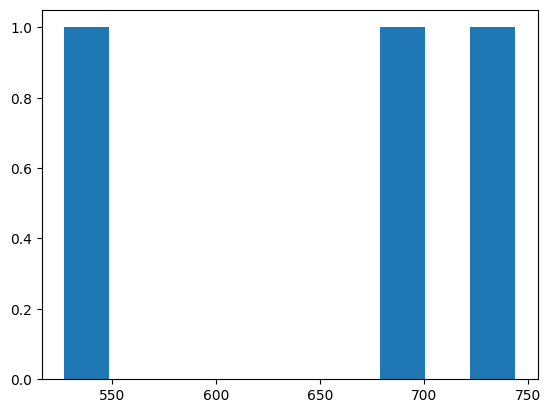

The statistics of article length: count      3.000000
mean     650.666667
std      111.634821
min      527.000000
25%      604.000000
50%      681.000000
75%      712.500000
max      744.000000
dtype: float64


In [5]:

print_statitiscs(abs_intro.values())

## CtrlSumm - prompting

In [1]:
from transformers import AutoModelForSeq2SeqLM, PreTrainedTokenizerFast
from transformers.models.bart.modeling_bart import BartForConditionalGeneration
import pandas as pd
from allennlp_models.generation.models import Bart
from allennlp.data import Vocabulary
import torch
from allennlp.nn.beam_search import BeamSearch

model = BartForConditionalGeneration.from_pretrained("hyunwoongko/ctrlsum-arxiv")
tokenizer = PreTrainedTokenizerFast.from_pretrained("hyunwoongko/ctrlsum-arxiv")

def summary_by_allennlp( prompt, context ):
    print("Keyword/Prompt \n \t ", prompt)
    vocab = Vocabulary.from_pretrained_transformer("hyunwoongko/ctrlsum-arxiv") 
    bart_model = Bart(model_name="hyunwoongko/ctrlsum-arxiv", vocab=vocab)
    data = tokenizer([context+prompt], return_tensors="pt", padding="max_length", truncation=True )
    input_ids, attention_mask = data["input_ids"], data["attention_mask"]
    beam_search = BeamSearch(bart_model._end_id, vocab=vocab, beam_size=5)
    initial_decoder_id = torch.tensor( [[bart_model._decoder_start_id]], dtype=input_ids.dtype, device=input_ids.device ).repeat(input_ids.shape[0], 1)
    initial_state = {
        "input_ids": input_ids,
        "input_mask": attention_mask
    }

    beam_result = beam_search.search(initial_decoder_id, initial_state, bart_model.take_step)
    predictions = beam_result[0] # (bsz, beam_size, seq_len)

    max_pred_indices = (
        beam_result[1].argmax(dim=-1).view(-1, 1, 1).expand(-1, -1, predictions.shape[-1])
    ) # (bsz, 1, seq_len)
    out = predictions.gather(dim=1, index=max_pred_indices)# (bsz, 1, seq_len)
    out = out.squeeze(dim=1) 

    predicted_text = bart_model.make_output_human_readable({"predictions": out})['predicted_text']

    print("Summary \n \t ", predicted_text[0])
    print('\n')
    return predicted_text[0]

    # import numpy as np
    # print(max_pred_indices.numpy().shape)
    # print(predictions.numpy().shape)
    # np.take(predictions.numpy(), indices=max_pred_indices.numpy(), axis=1) # (2, 2, 1, 50, 50)

def output_structured_summary(documents):
    results = {}
    for paper_title, content in documents.items():
        
        method = summary_by_allennlp("Q:What is the proposed method or technique in the paper? A: => ", content)
        empirical_result = summary_by_allennlp("findings or experimental results => ", content)
        contributions = summary_by_allennlp("the main contributions of this paper are: (1) => ", content)
        results[paper_title] = [method, empirical_result, contributions]
    return pd.DataFrame.from_dict(results, orient='index',
                           columns=['Method', 'Result', 'Contributions'])


In [41]:
structured_summary = output_structured_summary(abstracts)
structured_summary.to_csv('abstract_summaries.csv')

Keyword/Prompt 
 	  Q:What is the proposed method or technique in the paper? A: => 
Summary 
 	   in this paper, we introduce a new language representation model called the bidirectional language representation model called the bidirectional language representation model called the bidirectional language representation model called the bidirectional language representation model called the bidirectional language representation


Keyword/Prompt 
 	  findings or experimental results => 
Summary 
 	   in this paper, we introduce a new language representation model called the bidirectional language representation model called the bidirectional language representation model called the bidirectional language representation model called the bidirectional language representation model called the bidirectional language representation


Keyword/Prompt 
 	  the main contributions of this paper are: (1) => 
Summary 
 	   in this paper, we introduce a new language representation model called the bi

In [45]:
structured_summary = output_structured_summary(abs_intro)
structured_summary.to_csv('abs_intro_summaries.csv')

Keyword/Prompt 
 	  Q:What is the proposed method or technique in the paper? A: => 
Summary 
 	   in this paper, we introduce a new language representation model called bidirectional language models for pre- training that achieves state-of - the - art performance on a large suite of natural language processing tasks, including sentence-level tasks such as natural language


Keyword/Prompt 
 	  findings or experimental results => 
Summary 
 	   in this paper, we introduce a new language representation model called bidirectional language models for pre- training that achieves state-of - the - art performance on a large suite of natural language processing tasks, including sentence-level tasks such as natural language


Keyword/Prompt 
 	  the main contributions of this paper are: (1) => 
Summary 
 	   in this paper, we introduce a new language representation model called bidirectional language models for pre- training that achieves state-of - the - art performance on a large suite of nat